In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('default')

import functools
import warnings

from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit


In [ ]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.mean(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the path to the folder
folder_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# List the contents of the folder
contents = os.listdir(folder_path)
print(contents)


['ood_train_set_2.csv', 'ood_test_set_2.csv', 'filtered_df_2319.csv', 'random_df_train_org.csv', 'random_df_test_org.csv', 'wd_train_set_org.csv', 'wd_test_set_org.csv', 'ood_test_set_org.csv', 'ood_train_set_org.csv']


In [ ]:

#import pandas as pd

# Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# Load the three in situ scenarios
random_train_df = pd.read_csv(f'{base_path}/random_df_train_org.csv')
random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')

<ipython-input-5-70d53503eec4>:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')


#1. Random split

In [ ]:
# load here the already scaled data and test it

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
X_train = random_train_df[rrs_columns].values
X_test = random_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_train = random_train_df[y_columns].values
y_test = random_test_df[y_columns].values

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers, Sequential

class DropConnectDense(layers.Layer):
    def __init__(self, units, activation=None, dropout_rate=0.25, l2_reg=1e-3, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = regularizers.l2(l2_reg)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=self.kernel_regularizer,
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate dropout mask for weights
            dropout_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.dropout_rate)
            w = self.w * dropout_mask
        else:
            w = self.w
        output = tf.matmul(inputs, w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])   # positive and not zero
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_bnn_dropconnect(input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    # Adding explicit names to each layer
    model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, input_shape=input_shape, name='drop_connect_dense_1'))
    for i in range(1, n_layers):
        model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, name=f'drop_connect_dense_{i+1}'))
    model.add(layers.Dense(output_size * 2, activation='linear', name='output_dense'))  # Naming the output layer explicitly
    return model

def train_bnn_dropconnect(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Use the custom NLL loss for training
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

# Example usage:
# Assuming X_train and y_train_scaled are defined and preprocessed.
model = build_bnn_dropconnect(input_shape=(X_train.shape[1],), hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6)
model = train_bnn_dropconnect(model, X_train, y_train_scaled, epochs=1000, batch_size=32, learning_rate=0.001)


Epoch 1/1000
33/33 [==============================] - 2s 12ms/step - loss: 0.8745 - val_loss: 0.6932
Epoch 2/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.4636 - val_loss: 0.2881
Epoch 3/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.3859 - val_loss: 0.4840
Epoch 4/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.3437 - val_loss: 0.2550
Epoch 5/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.2481 - val_loss: 0.0667
Epoch 6/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: -0.0373
Epoch 7/1000
33/33 [==============================] - 0s 5ms/step - loss: -0.0292 - val_loss: -0.1043
Epoch 8/1000
33/33 [==============================] - 0s 5ms/step - loss: -0.1263 - val_loss: -0.2378
Epoch 9/1000
33/33 [==============================] - 0s 4ms/step - loss: -0.1479 - val_loss: -0.1688
Epoch 10/1000
33/33 [==============================] - 0s 4ms/step - loss: -0.2124 - val_los

KeyboardInterrupt: 

In [ ]:
def predict_with_uncertainty(model, X, scaler_y, n_samples=100):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, scales these back to the original scale,
    then calculates the aleatoric and epistemic uncertainties of the predictions.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance: np.ndarray
        The epistemic variance on the original scale.
    std_devs: np.ndarray
        The standard deviations of the predictions on the original scale.
        Simply sqrt(total_variance), provided separately for convenience.
    """
    # Generate predictions in scaled space
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)


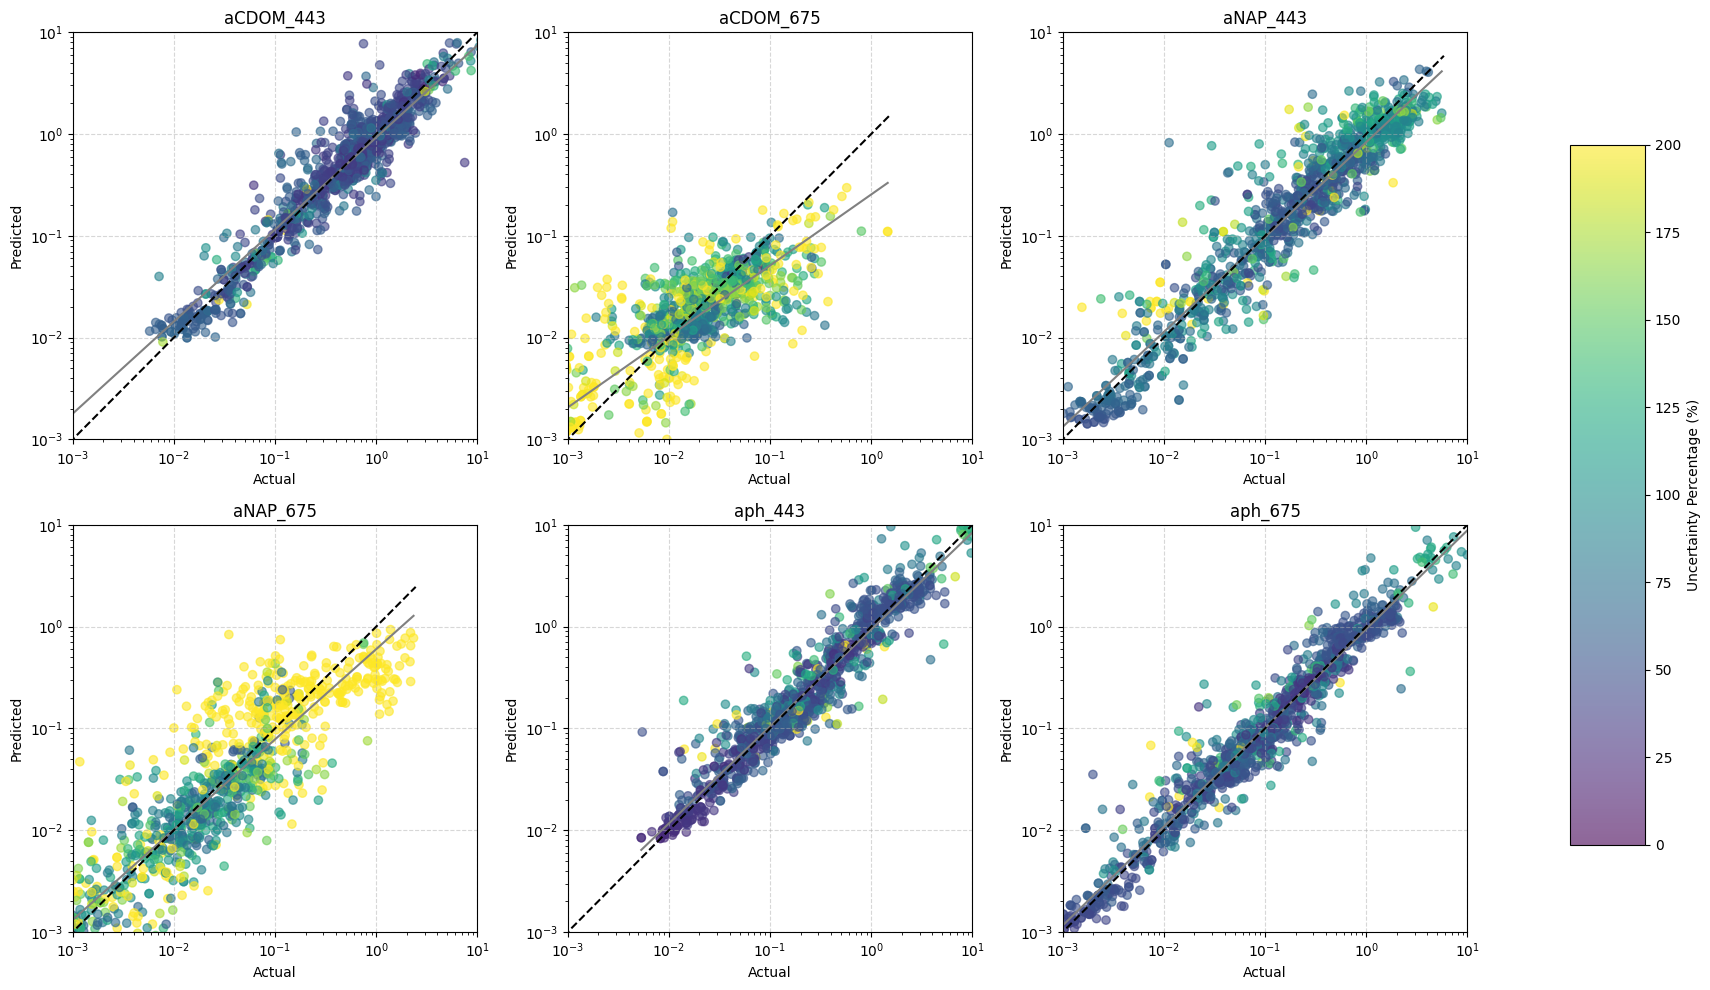

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

# Assuming wd_y_test, wd_mean_predictions are numpy arrays and y_columns is a list of column names
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


In [ ]:
metrics_df

obs_cor        MAPD       MAD       sspb       mdsa
aCDOM_443     1160  164.696665  0.390744  -2.666424  25.130081
aCDOM_675     1160  788.303128  1.047509  -3.975026  63.606028
aNAP_443      1160   64.880654  0.596862 -13.303500  43.044114
aNAP_675      1160   96.682674  0.944083  -8.292712  65.888641
aph_443       1160   40.714233  0.390265  -3.244186  27.726760
aph_675       1160   40.888731  0.389390  -0.814360  25.948020

In [ ]:
# 10 networks

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


In [ ]:
class DropConnectDense(layers.Layer):
    def __init__(self, units, activation=None, dropout_rate=0.25, l2_reg=1e-3, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = regularizers.l2(l2_reg)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=self.kernel_regularizer,
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate dropout mask for weights
            dropout_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.dropout_rate)
            w = self.w * dropout_mask
        else:
            w = self.w
        output = tf.matmul(inputs, w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])   # positive and not zero
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_bnn_dropconnect(input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    # Adding explicit names to each layer
    model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, input_shape=input_shape, name='drop_connect_dense_1'))
    for i in range(1, n_layers):
        model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, name=f'drop_connect_dense_{i+1}'))
    model.add(layers.Dense(output_size * 2, activation='linear', name='output_dense'))  # Naming the output layer explicitly
    return model

def train_bnn_dropconnect(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Use the custom NLL loss for training
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_with_uncertainty(model, X, scaler_y, n_samples=100):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, scales these back to the original scale,
    then calculates the aleatoric and epistemic uncertainties of the predictions.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance: np.ndarray
        The epistemic variance on the original scale.
    std_devs: np.ndarray
        The standard deviations of the predictions on the original scale.
        Simply sqrt(total_variance), provided separately for convenience.
    """
    # Generate predictions in scaled space
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001, n_samples=100):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_bnn_dropconnect(input_shape=input_shape, hidden_units=hidden_units, n_layers=n_layers,
                              dropout_rate=dropout_rate, l2_reg=l2_reg, activation=activation, output_size=output_size)
        model = train_bnn_dropconnect(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

        print('Calculating mean_preds.')
        mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)
        print('Completed predict with uncertainty.')
        print('Calculating metrics.')
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['aCDOM_443', 'aNAP_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

#### starts here:

# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
X_train = random_train_df[rrs_columns].values
X_test = random_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_train = random_train_df[y_columns].values
y_test = random_test_df[y_columns].values

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)

# Call
best_model, best_model_index, mdsa_df= train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns,scaler_y=scaler_y, input_shape = (X_train.shape[1],), num_models=10)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 318/1000
33/33 [==============================] - 0s 6ms/step - loss: -0.7402 - val_loss: -0.7413
Epoch 319/1000
33/33 [==============================] - 0s 6ms/step - loss: -0.7194 - val_loss: -0.7841
Epoch 320/1000
33/33 [==============================] - 0s 7ms/step - loss: -0.7331 - val_loss: -0.7840
Epoch 321/1000
33/33 [==============================] - 0s 6ms/step - loss: -0.7284 - val_loss: -0.7581
Epoch 322/1000
33/33 [==============================] - 0s 6ms/step - loss: -0.7110 - val_loss: -0.7705
Epoch 323/1000
33/33 [==============================] - 0s 8ms/step - loss: -0.7059 - val_loss: -0.7537
Epoch 324/1000
33/33 [==============================] - 0s 8ms/step - loss: -0.6969 - val_loss: -0.7619
Epoch 325/1000
33/33 [==============================] - 0s 8ms/step - loss: -0.7268 - val_loss: -0.7827
Epoch 326/1000
33/33 [==============================] - 0s 7ms/step - loss: -0.7212 - val_loss: -0.77

In [ ]:
# refresh before saving - might time out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mdsa_df

aCDOM_443  aCDOM_675   aNAP_443   aNAP_675    aph_443    aph_675
0  24.915827  62.589103  41.955060  60.040361  29.198987  26.491463
1  26.565570  60.054196  44.710751  68.080685  28.019920  29.374213
2  26.646941  64.159711  43.118521  58.833050  28.388543  27.726192
3  24.777612  59.884670  40.569738  58.820643  28.501353  26.783690
4  22.830554  65.642081  42.697352  63.377800  28.355282  28.998218
5  22.962949  60.975320  43.557455  60.497313  29.113729  26.960446
6  24.910088  64.040064  40.852863  68.825375  29.517896  29.257589
7  26.236233  60.866146  42.524616  59.281642  30.004859  26.800279
8  23.644294  61.098375  45.321604  69.093151  31.256590  30.348403
9  25.335996  60.511565  42.418430  63.059871  27.581953  26.881753

In [ ]:
mdsa_df.std()

aCDOM_443    1.391458
aCDOM_675    2.001654
aNAP_443     1.505120
aNAP_675     4.225583
aph_443      1.076616
aph_675      1.397128
dtype: float64

In [ ]:
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_random_mdsa_df_10_networks.csv'
mdsa_df.to_csv(file_path, index=False)

In [ ]:
folder_path = '/content/drive/My Drive/iop_ml/best_models'
model_path = os.path.join(folder_path, 'bnn_dropcon_random_split_best.keras')
# Save the model in the recommended format
best_model.save(model_path)

In [ ]:
# Define the path to the saved model
model_path = '/content/drive/My Drive/iop_ml/best_models/bnn_dropcon_random_split_best.keras'

# Load the model
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

In [ ]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(loaded_model, X_test, scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

In [ ]:
metrics_df

obs_cor        MAPD       MAD       sspb       mdsa
aCDOM_443     1160   90.274999  0.390721  -1.432452  24.710114
aCDOM_675     1160  657.731921  1.055446  10.828150  62.694372
aNAP_443      1160   66.156127  0.563373  -1.754396  40.647715
aNAP_675      1160  101.512479  0.912497   2.603781  59.893860
aph_443       1160   38.679647  0.387627  -3.028869  26.832064
aph_675       1160   38.576500  0.387693  -3.053148  26.688407

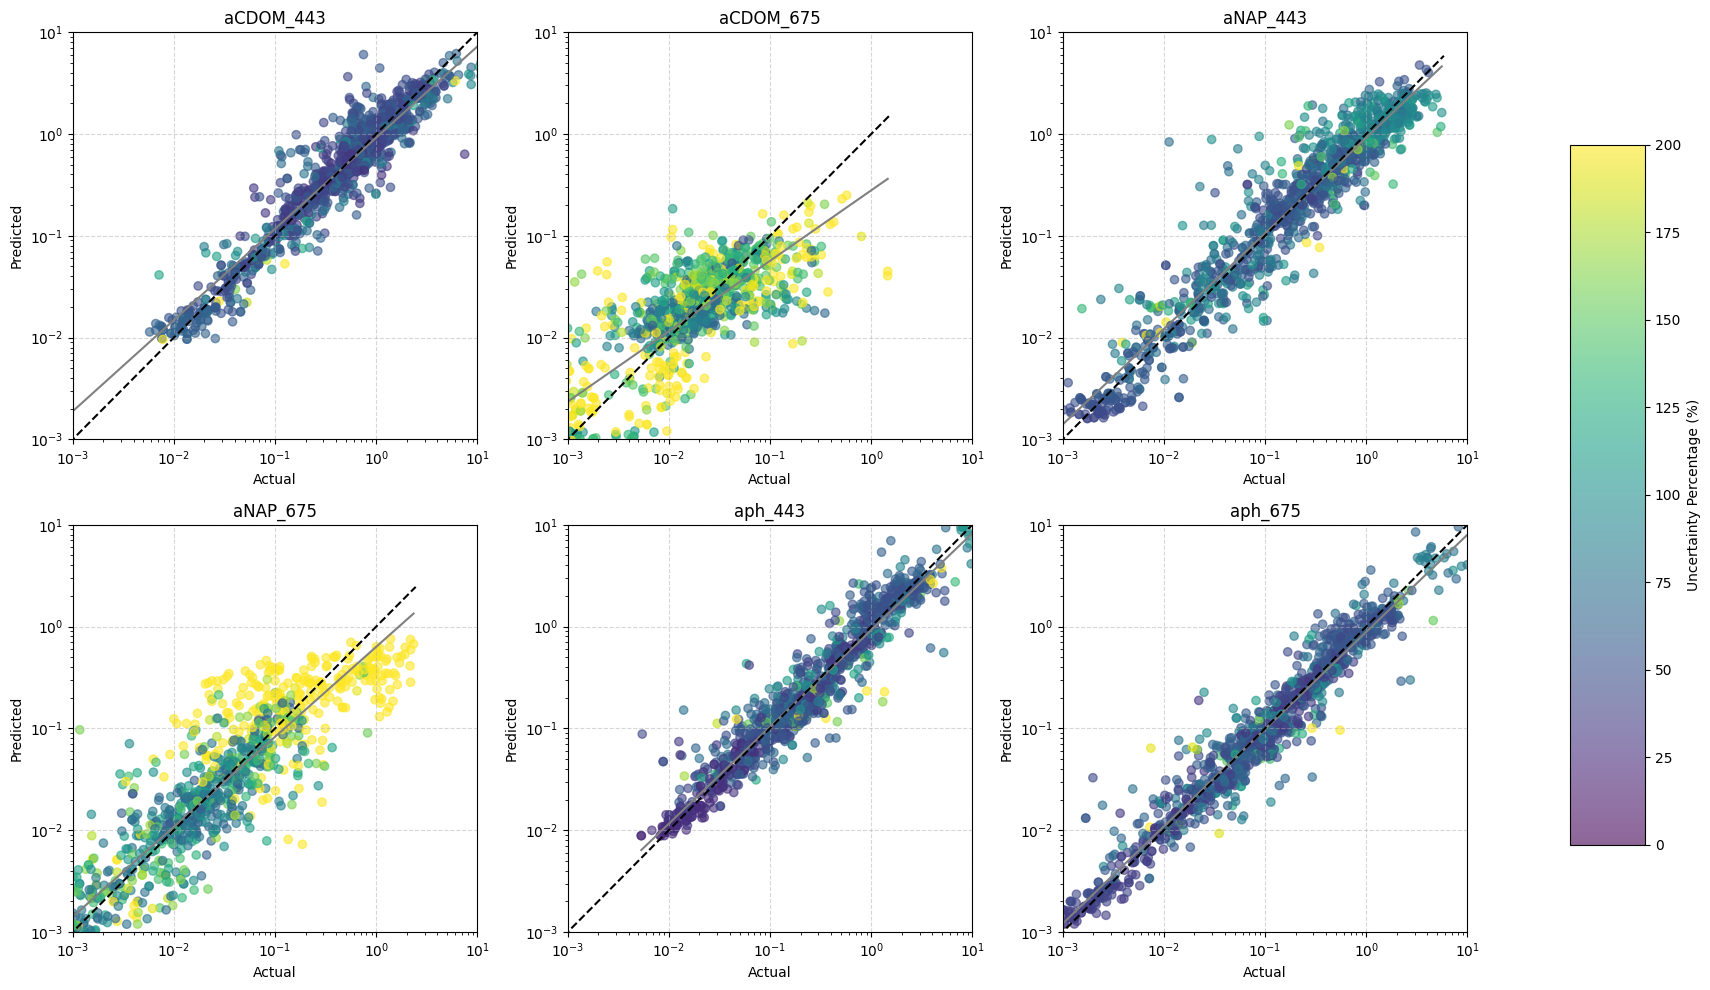

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_random_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# WD and OOD

In [ ]:
#import pandas as pd

#Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')

<ipython-input-12-aa57256325b2>:6: DtypeWarning: Columns (3,4,5,6,8,11,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
<ipython-input-12-aa57256325b2>:7: DtypeWarning: Columns (4,5,34,37,39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
wd_X_train = wd_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
wd_X_test = wd_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
# y_columns = ['aCDOM_443', 'aNAP_443', 'aph_443']

wd_y_train = wd_train_df[y_columns].values
wd_y_test = wd_test_df[y_columns].values

# Apply log transformation to the target variables
wd_y_train_log = np.log(wd_y_train)
wd_y_test_log = np.log(wd_y_test)

# Apply Min-Max scaling to log-transformed target variables
wd_scaler_y = MinMaxScaler(feature_range=(-1, 1))
wd_y_train_scaled = wd_scaler_y.fit_transform(wd_y_train_log)
wd_y_test_scaled = wd_scaler_y.transform(wd_y_test_log)


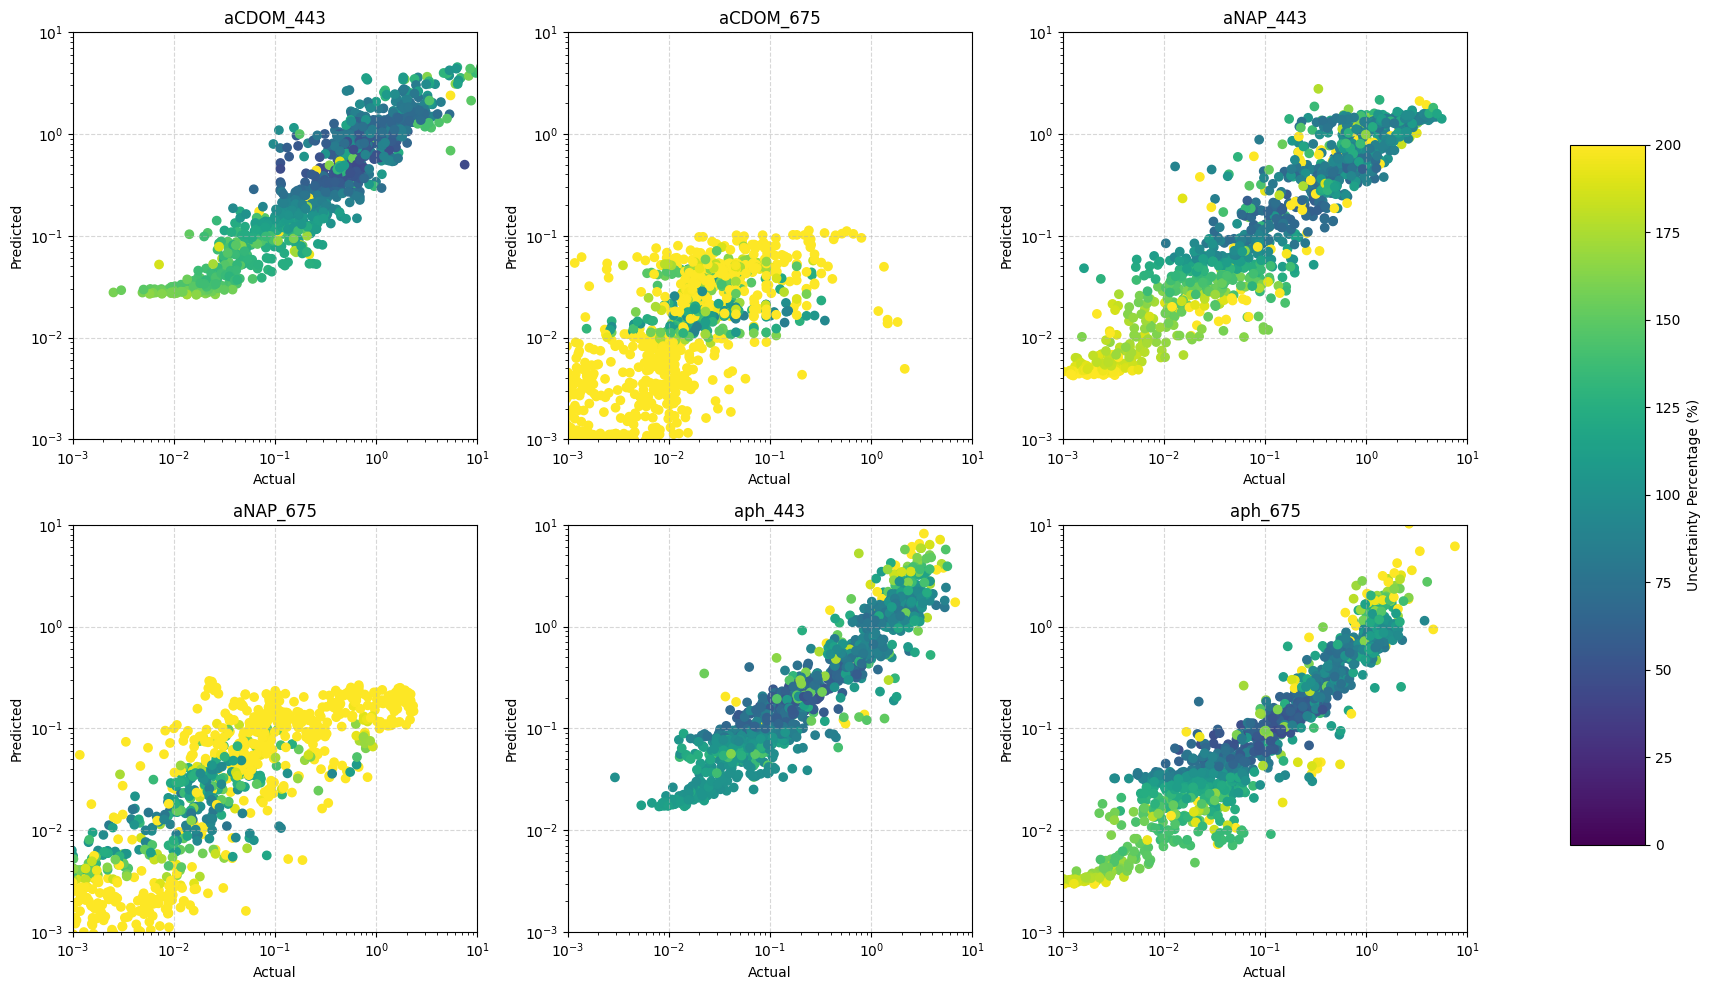

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your mean_predictions and uncertainties here
# For demonstration, these are placeholders and should be replaced with your actual data
# total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty are arrays with the shape of (number of samples, number of variables)

# Calculate percentage uncertainties relative to the mean predictions
wd_percent_total_uncertainty = (np.sqrt(wd_total_var) / wd_mean_preds) * 100
wd_percent_aleatoric_uncertainty = (np.sqrt(wd_aleatoric_var) / wd_mean_preds) * 100
wd_percent_epistemic_uncertainty = (np.sqrt(wd_epistemic_var) / wd_mean_preds) * 100

# Cap the maximum uncertainty at 300% for visualization
# wd_percent_total_uncertainty[wd_percent_total_uncertainty > 30] = 30
# wd_percent_aleatoric_uncertainty[wd_percent_aleatoric_uncertainty > 30] = 30
# wd_percent_epistemic_uncertainty[wd_percent_epistemic_uncertainty > 30] = 30

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (wd_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = wd_mean_preds[:, i][mask[:, i]]
    color_values = wd_percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties
    ax.grid(True, ls='--', alpha=0.5)
    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=1)
    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)


# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


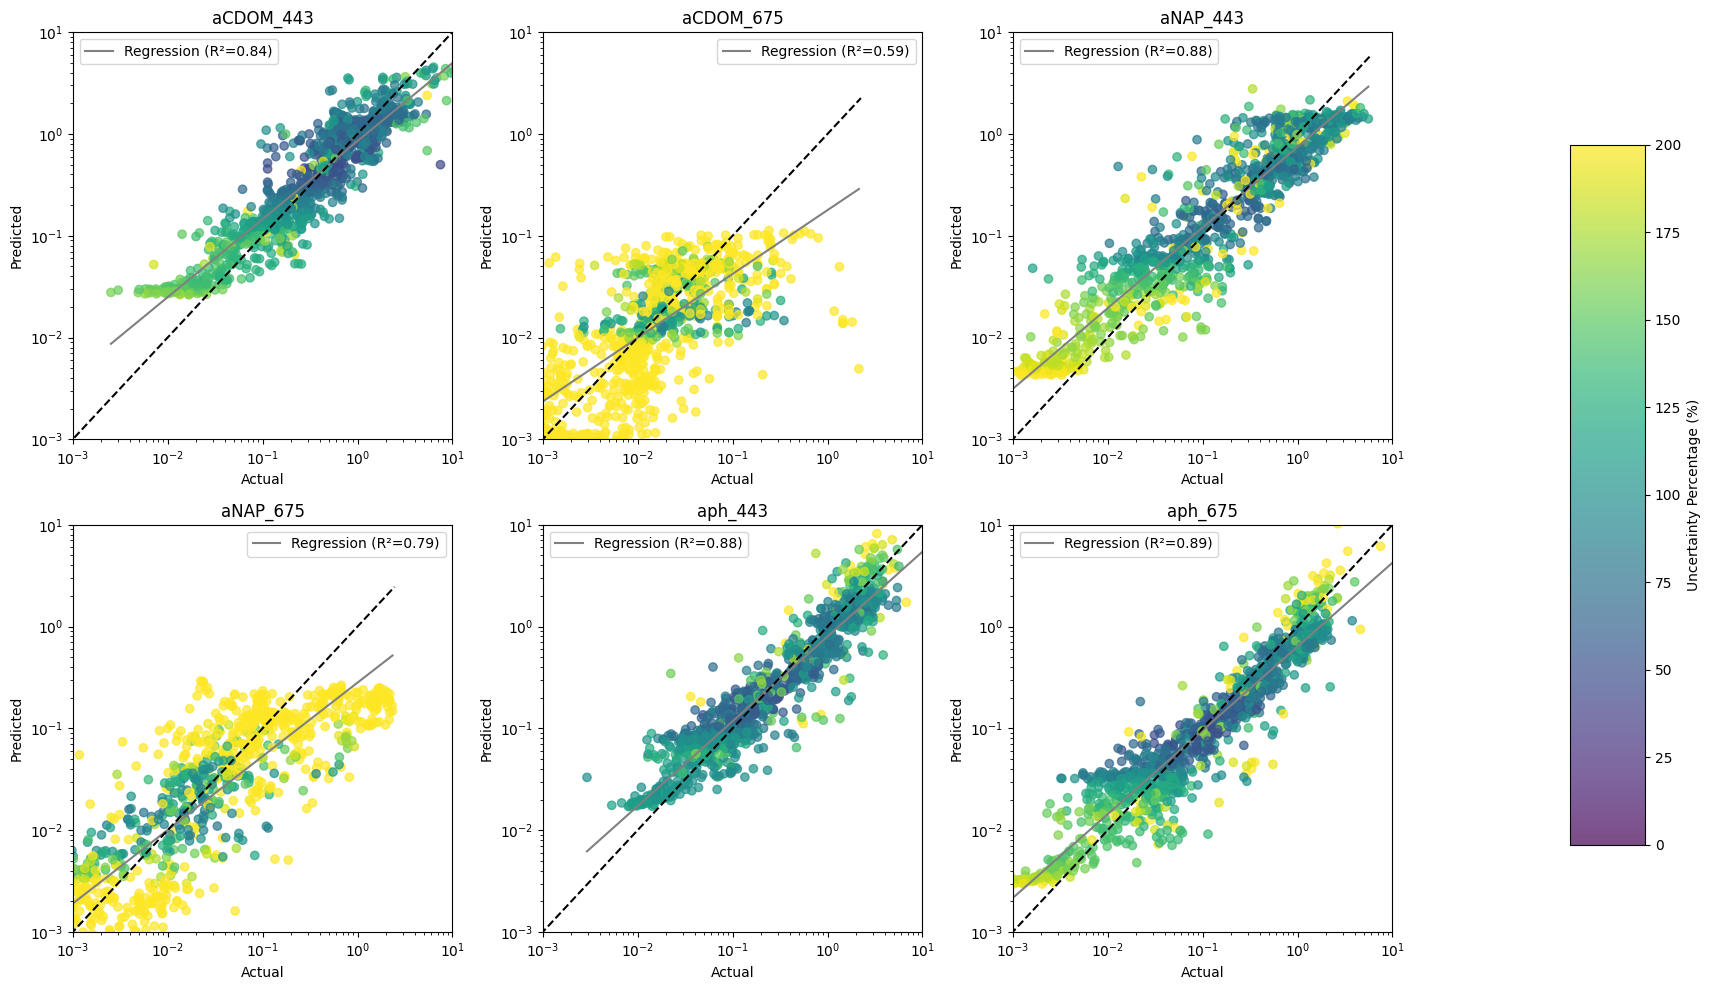

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
norm = plt.Normalize(vmin=0, vmax=200)


for i, ax in enumerate(axs):
    x_values = y_test[:, i][mask[:, i]]
    y_values = wd_mean_preds[:, i][mask[:, i]]
    color_values = wd_percent_total_uncertainty[:, i][mask[:, i]]

    # Scatter plot
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.7)

    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.legend()

plt.tight_layout(rect=[0, 0, 0.95, 1])
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')
plt.show()

In [ ]:
class DropConnectDense(layers.Layer):
    def __init__(self, units, activation=None, dropout_rate=0.25, l2_reg=1e-3, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = regularizers.l2(l2_reg)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=self.kernel_regularizer,
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate dropout mask for weights
            dropout_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.dropout_rate)
            w = self.w * dropout_mask
        else:
            w = self.w
        output = tf.matmul(inputs, w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])   # positive and not zero
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_bnn_dropconnect(input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    # Adding explicit names to each layer
    model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, input_shape=input_shape, name='drop_connect_dense_1'))
    for i in range(1, n_layers):
        model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, name=f'drop_connect_dense_{i+1}'))
    model.add(layers.Dense(output_size * 2, activation='linear', name='output_dense'))  # Naming the output layer explicitly
    return model

def train_bnn_dropconnect(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Use the custom NLL loss for training
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_with_uncertainty(model, X, scaler_y, n_samples=100):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, scales these back to the original scale,
    then calculates the aleatoric and epistemic uncertainties of the predictions.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance: np.ndarray
        The epistemic variance on the original scale.
    std_devs: np.ndarray
        The standard deviations of the predictions on the original scale.
        Simply sqrt(total_variance), provided separately for convenience.
    """
    # Generate predictions in scaled space
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001, n_samples=100):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_bnn_dropconnect(input_shape=input_shape, hidden_units=hidden_units, n_layers=n_layers,
                              dropout_rate=dropout_rate, l2_reg=l2_reg, activation=activation, output_size=output_size)
        model = train_bnn_dropconnect(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

        print('Calculating mean_preds.')
        mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)
        print('Completed predict with uncertainty.')
        print('Calculating metrics.')
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['aCDOM_443', 'aNAP_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

#### starts here:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
wd_X_train = wd_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
wd_X_test = wd_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

wd_y_train = wd_train_df[y_columns].values
wd_y_test = wd_test_df[y_columns].values

# Apply log transformation to the target variables
wd_y_train_log = np.log(wd_y_train)
wd_y_test_log = np.log(wd_y_test)

# Apply Min-Max scaling to log-transformed target variables
wd_scaler_y = MinMaxScaler(feature_range=(-1, 1))
wd_y_train_scaled = wd_scaler_y.fit_transform(wd_y_train_log)
wd_y_test_scaled = wd_scaler_y.transform(wd_y_test_log)

# Call
wd_best_model, wd_best_model_index, wd_mdsa_df= train_and_evaluate_models(wd_X_train, wd_y_train_scaled, wd_X_test, wd_y_test, y_columns, scaler_y=wd_scaler_y, input_shape = (wd_X_train.shape[1],), num_models=10)

Epoch 1/1000
33/33 [==============================] - 2s 11ms/step - loss: 0.8918 - val_loss: 0.7949
Epoch 2/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.5547 - val_loss: 1.0871
Epoch 3/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.5408 - val_loss: 0.6065
Epoch 4/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4443 - val_loss: 1.1610
Epoch 5/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.5434 - val_loss: 1.2468
Epoch 6/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.2649 - val_loss: 0.9674
Epoch 7/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.3082 - val_loss: 0.5645
Epoch 8/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.2608 - val_loss: 1.6552
Epoch 9/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.1781 - val_loss: 1.0636
Epoch 10/1000
33/33 [==============================] - 0s 8ms/step - loss: 0.0942 - val_loss: 0.660

In [ ]:
wd_mdsa_df

aCDOM_443  aCDOM_675   aNAP_443    aNAP_675    aph_443    aph_675
0  44.686797  88.927254  64.682495  112.417042  36.677761  49.273057
1  37.535152  91.996216  56.497266  105.603310  37.815342  43.769777
2  39.079783  93.316525  54.768831  115.982647  48.308274  44.098387
3  40.617184  87.153295  55.081267  123.005873  43.783811  51.057045
4  43.553486  86.110210  57.061149  112.291315  45.458868  40.550354
5  42.943638  95.729567  68.913569  115.337346  65.345458  82.383762
6  44.020093  88.395513  56.020408  113.877679  36.652732  45.447051
7  42.231914  87.985687  60.503130  116.151127  40.337634  43.375481
8  50.880661  96.416540  50.567392  115.619014  36.633901  39.607619
9  41.886635  89.156885  59.418394  130.492752  36.132334  43.889655

In [ ]:
wd_mdsa_df.std()
#

aCDOM_443     3.626791
aCDOM_675     3.621243
aNAP_443      5.292196
aNAP_675      6.657129
aph_443       9.038576
aph_675      12.453749
dtype: float64

In [ ]:
wd_mdsa_df

aCDOM_443  aCDOM_675   aNAP_443    aNAP_675    aph_443    aph_675
0  44.686797  88.927254  64.682495  112.417042  36.677761  49.273057
1  37.535152  91.996216  56.497266  105.603310  37.815342  43.769777
2  39.079783  93.316525  54.768831  115.982647  48.308274  44.098387
3  40.617184  87.153295  55.081267  123.005873  43.783811  51.057045
4  43.553486  86.110210  57.061149  112.291315  45.458868  40.550354
5  42.943638  95.729567  68.913569  115.337346  65.345458  82.383762
6  44.020093  88.395513  56.020408  113.877679  36.652732  45.447051
7  42.231914  87.985687  60.503130  116.151127  40.337634  43.375481
8  50.880661  96.416540  50.567392  115.619014  36.633901  39.607619
9  41.886635  89.156885  59.418394  130.492752  36.132334  43.889655

In [ ]:
# refresh before saving - might time out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/My Drive/iop_ml/best_models'
model_path = os.path.join(folder_path, 'bnn_dropcon_wd_split_best.keras')
# Save the model in the recommended format
wd_best_model.save(model_path)

In [ ]:
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_wd_mdsa_df_10_networks.csv'
wd_mdsa_df.to_csv(file_path, index=False)

In [ ]:
# Define the path to the saved model
model_path = '/content/drive/My Drive/iop_ml/best_models/bnn_dropcon_wd_split_best.keras'

# Load the model
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

In [ ]:
# load best model, make preds, save them

In [ ]:
wd_mean_preds, wd_total_var, wd_aleatoric_var, wd_epistemic_var, wd_std_preds = predict_with_uncertainty(loaded_model, wd_X_test, wd_scaler_y, n_samples=100)

In [ ]:
metrics_df = calculate_and_store_metrics(wd_y_test, wd_mean_preds, y_columns)

In [ ]:
metrics_df

obs_cor        MAPD       MAD       sspb        mdsa
aCDOM_443     1160   60.827760  0.554302   6.710300   37.535152
aCDOM_675     1160  274.619707  1.341765 -17.308762   91.996216
aNAP_443      1160   76.509331  0.741261  -8.954082   56.497266
aNAP_675      1160  111.626689  1.586406 -21.075627  105.603310
aph_443       1160   57.914828  0.525854   6.351495   37.815342
aph_675       1160   58.294536  0.602968  -5.491566   43.769777

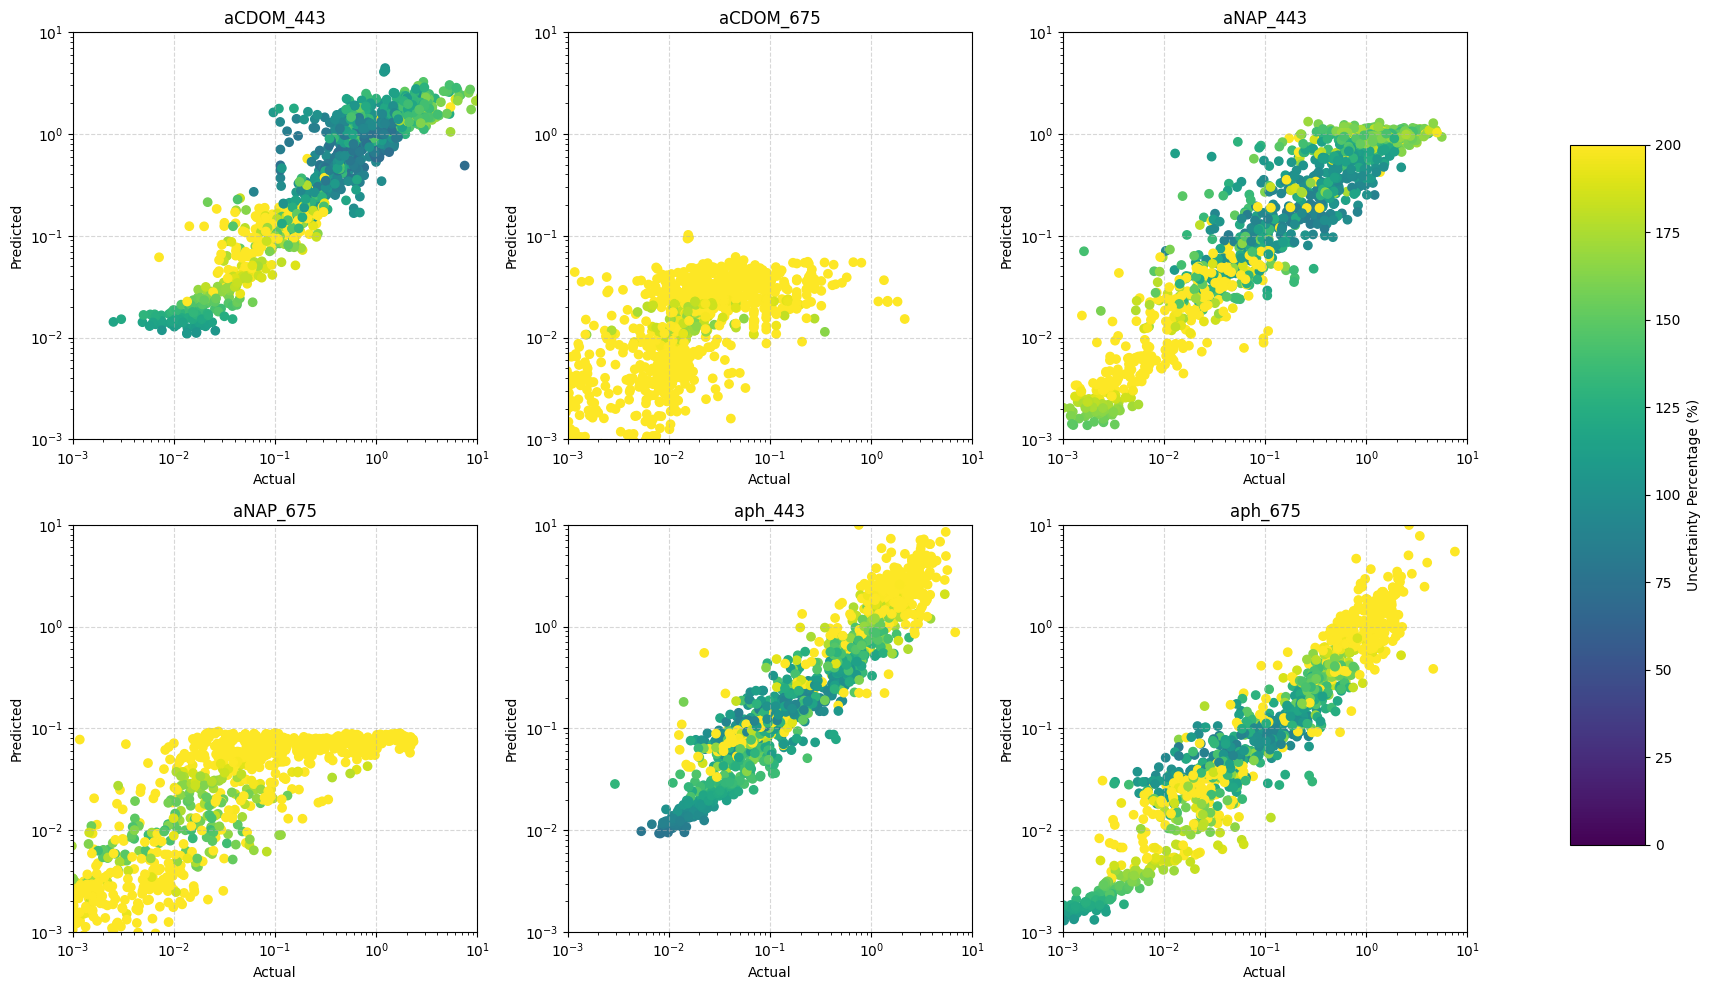

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your mean_predictions and uncertainties here
# For demonstration, these are placeholders and should be replaced with your actual data
# total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty are arrays with the shape of (number of samples, number of variables)

# Calculate percentage uncertainties relative to the mean predictions
wd_percent_total_uncertainty = (np.sqrt(wd_total_var) / wd_mean_preds) * 100
wd_percent_aleatoric_uncertainty = (np.sqrt(wd_aleatoric_var) / wd_mean_preds) * 100
wd_percent_epistemic_uncertainty = (np.sqrt(wd_epistemic_var) / wd_mean_preds) * 100

# Cap the maximum uncertainty at 300% for visualization
# wd_percent_total_uncertainty[wd_percent_total_uncertainty > 30] = 30
# wd_percent_aleatoric_uncertainty[wd_percent_aleatoric_uncertainty > 30] = 30
# wd_percent_epistemic_uncertainty[wd_percent_epistemic_uncertainty > 30] = 30

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (wd_y_test > 1e-4) & (wd_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = wd_y_test[:, i][mask[:, i]]
    y_values = wd_mean_preds[:, i][mask[:, i]]
    color_values = wd_percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties
    ax.grid(True, ls='--', alpha=0.5)
    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=1)
    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)


# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    wd_y_test,
    wd_mean_preds,
    wd_total_var,
    wd_aleatoric_var,
    wd_epistemic_var,
    wd_std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_wd_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# OOD

In [ ]:
#import pandas as pd

#Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_2.csv')
ood_test_df = pd.read_csv(f'{base_path}/ood_test_set_2.csv')

filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')

<ipython-input-40-b373918ea68f>:9: DtypeWarning: Columns (3,4,5,6,8,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
ood_X_train = ood_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
ood_X_test = ood_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
#y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_columns = ['org_acdom_443', 'org_acdom_675', 'org_anap_443', 'org_anap_675','org_aph_443', 'org_aph_675']
ood_y_train = ood_train_df[y_columns].values
ood_y_test = ood_test_df[y_columns].values

# Apply log transformation to the target variables
ood_y_train_log = np.log(ood_y_train)
ood_y_test_log = np.log(ood_y_test)

# Apply Min-Max scaling to log-transformed target variables
ood_scaler_y = MinMaxScaler(feature_range=(-1, 1))
ood_y_train_scaled = ood_scaler_y.fit_transform(ood_y_train_log)
ood_y_test_scaled = ood_scaler_y.transform(ood_y_test_log)

In [ ]:
class DropConnectDense(layers.Layer):
    def __init__(self, units, activation=None, dropout_rate=0.25, l2_reg=1e-3, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = regularizers.l2(l2_reg)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=self.kernel_regularizer,
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate dropout mask for weights
            dropout_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.dropout_rate)
            w = self.w * dropout_mask
        else:
            w = self.w
        output = tf.matmul(inputs, w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])   # positive and not zero
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_bnn_dropconnect(input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    # Adding explicit names to each layer
    model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, input_shape=input_shape, name='drop_connect_dense_1'))
    for i in range(1, n_layers):
        model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, name=f'drop_connect_dense_{i+1}'))
    model.add(layers.Dense(output_size * 2, activation='linear', name='output_dense'))  # Naming the output layer explicitly
    return model

def train_bnn_dropconnect(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Use the custom NLL loss for training
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_with_uncertainty(model, X, scaler_y, n_samples=100):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, scales these back to the original scale,
    then calculates the aleatoric and epistemic uncertainties of the predictions.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance: np.ndarray
        The epistemic variance on the original scale.
    std_devs: np.ndarray
        The standard deviations of the predictions on the original scale.
        Simply sqrt(total_variance), provided separately for convenience.
    """
    # Generate predictions in scaled space
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001, n_samples=100):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_bnn_dropconnect(input_shape=input_shape, hidden_units=hidden_units, n_layers=n_layers,
                              dropout_rate=dropout_rate, l2_reg=l2_reg, activation=activation, output_size=output_size)
        model = train_bnn_dropconnect(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

        print('Calculating mean_preds.')
        mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)
        print('Completed predict with uncertainty.')
        print('Calculating metrics.')
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['org_acdom_443', 'org_anap_443', 'org_aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

#### starts here:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
ood_X_train = ood_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
ood_X_test = ood_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
#y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_columns = ['org_acdom_443', 'org_acdom_675', 'org_anap_443', 'org_anap_675','org_aph_443', 'org_aph_675']
ood_y_train = ood_train_df[y_columns].values
ood_y_test = ood_test_df[y_columns].values

# Apply log transformation to the target variables
ood_y_train_log = np.log(ood_y_train)
ood_y_test_log = np.log(ood_y_test)

# Apply Min-Max scaling to log-transformed target variables
ood_scaler_y = MinMaxScaler(feature_range=(-1, 1))
ood_y_train_scaled = ood_scaler_y.fit_transform(ood_y_train_log)
ood_y_test_scaled = ood_scaler_y.transform(ood_y_test_log)

# Call
ood_best_model, ood_best_model_index, ood_mdsa_df= train_and_evaluate_models(ood_X_train, ood_y_train_scaled, ood_X_test, ood_y_test, y_columns, scaler_y=ood_scaler_y, input_shape = (ood_X_train.shape[1],), num_models=10)

Epoch 1/1000
33/33 [==============================] - 4s 28ms/step - loss: 0.8875 - val_loss: 0.6828
Epoch 2/1000
33/33 [==============================] - 0s 9ms/step - loss: 0.7882 - val_loss: 1.3523
Epoch 3/1000
33/33 [==============================] - 0s 9ms/step - loss: 0.5263 - val_loss: 0.7373
Epoch 4/1000
33/33 [==============================] - 0s 11ms/step - loss: 0.3930 - val_loss: 0.5929
Epoch 5/1000
33/33 [==============================] - 0s 9ms/step - loss: 0.3290 - val_loss: 0.4041
Epoch 6/1000
33/33 [==============================] - 0s 9ms/step - loss: 0.3477 - val_loss: 0.5780
Epoch 7/1000
33/33 [==============================] - 0s 8ms/step - loss: 0.3539 - val_loss: 0.8176
Epoch 8/1000
33/33 [==============================] - 0s 8ms/step - loss: 0.1223 - val_loss: 0.4391
Epoch 9/1000
33/33 [==============================] - 0s 8ms/step - loss: 0.1405 - val_loss: 0.4845
Epoch 10/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0115 - val_loss: 1.0

In [ ]:
ood_mdsa_df

org_acdom_443  org_acdom_675  org_anap_443  org_anap_675  org_aph_443  \
0      35.580610      98.713244     88.514522    118.716379    44.612068   
1      35.701212      70.411288     82.989750    141.221091    57.165168   
2      39.054626      82.264286     70.859530    155.835958    51.381742   
3      41.314941      89.966645     84.869713    117.501410    46.585180   
4      36.420549      76.313170     70.628864    121.752099    45.626037   
5      49.022731      75.888104     76.955394    136.649096    56.737561   
6      53.111739      89.703826     95.720076    144.867251    48.446001   
7      40.404720      70.844092     60.367575    109.379696    47.182745   
8      36.579508     100.894668     76.963198    117.270993    46.106742   
9      38.050916      88.175433     64.494967    116.945575    43.751641   

   org_aph_675  
0    45.079057  
1    55.824341  
2    52.572049  
3    45.884151  
4    49.053808  
5    61.741371  
6    48.419395  
7    50.132676  
8    41.650309  
9    45.192187

In [ ]:
# refresh before saving - might time out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_ood_mdsa_df_10_networks.csv'
ood_mdsa_df.to_csv(file_path)

ood_mdsa_df.std()

org_acdom_443     5.959944
org_acdom_675    10.914334
org_anap_443     11.013072
org_anap_675     15.378256
org_aph_443       4.803107
org_aph_675       5.904959
dtype: float64

In [ ]:
ood_mdsa_df

org_acdom_443  org_acdom_675  org_anap_443  org_anap_675  org_aph_443  \
0      35.580610      98.713244     88.514522    118.716379    44.612068   
1      35.701212      70.411288     82.989750    141.221091    57.165168   
2      39.054626      82.264286     70.859530    155.835958    51.381742   
3      41.314941      89.966645     84.869713    117.501410    46.585180   
4      36.420549      76.313170     70.628864    121.752099    45.626037   
5      49.022731      75.888104     76.955394    136.649096    56.737561   
6      53.111739      89.703826     95.720076    144.867251    48.446001   
7      40.404720      70.844092     60.367575    109.379696    47.182745   
8      36.579508     100.894668     76.963198    117.270993    46.106742   
9      38.050916      88.175433     64.494967    116.945575    43.751641   

   org_aph_675  
0    45.079057  
1    55.824341  
2    52.572049  
3    45.884151  
4    49.053808  
5    61.741371  
6    48.419395  
7    50.132676  
8    41.650309  
9    45.192187

In [ ]:
folder_path = '/content/drive/My Drive/iop_ml/best_models'
model_path = os.path.join(folder_path, 'bnn_dropcon_ood_split_best.keras')
# Save the model in the recommended format
ood_best_model.save(model_path)

# Define the path to the saved model
model_path = '/content/drive/My Drive/iop_ml/best_models/bnn_dropcon_ood_split_best.keras'

# Load the model
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

In [ ]:
ood_mean_preds, ood_total_var, ood_aleatoric_var, ood_epistemic_var, ood_std_preds = predict_with_uncertainty(loaded_model, ood_X_test, ood_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(ood_y_test, ood_mean_preds, y_columns)

In [ ]:
metrics_df

obs_cor         MAPD       MAD       sspb        mdsa
org_acdom_443     1159    55.011709  0.619200  -2.588695   38.050916
org_acdom_675     1159   273.338990  1.277564 -53.017117   88.175433
org_anap_443      1159   123.864594  0.868823 -35.528240   64.494967
org_anap_675      1159  1477.411263  1.831500  -0.835173  116.945575
org_aph_443       1159    68.836392  0.653451  -1.736597   43.751641
org_aph_675       1159    67.772926  0.676228   4.390785   45.192187

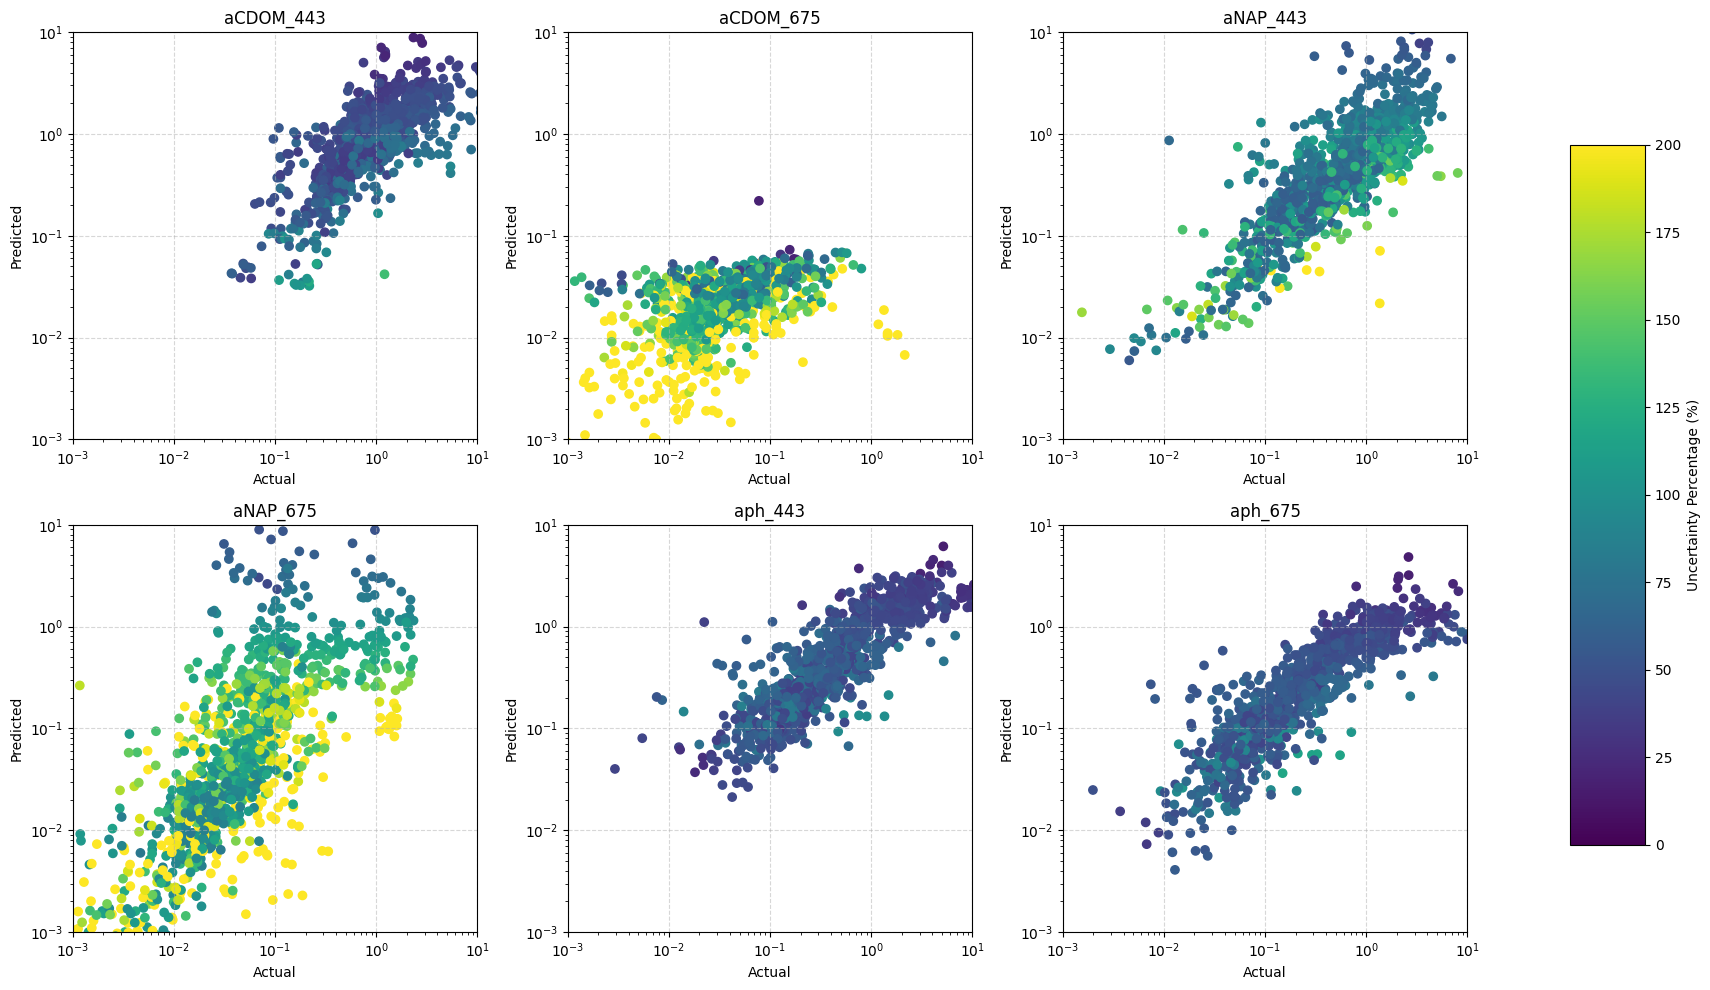

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your mean_predictions and uncertainties here
# For demonstration, these are placeholders and should be replaced with your actual data
# total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty are arrays with the shape of (number of samples, number of variables)

# Calculate percentage uncertainties relative to the mean predictions
ood_percent_total_uncertainty = (np.sqrt(ood_total_var) / ood_mean_preds) * 100
ood_percent_aleatoric_uncertainty = (np.sqrt(ood_aleatoric_var) / ood_mean_preds) * 100
ood_percent_epistemic_uncertainty = (np.sqrt(ood_epistemic_var) / ood_mean_preds) * 100

# Cap the maximum uncertainty at 300% for visualization
# wd_percent_total_uncertainty[wd_percent_total_uncertainty > 30] = 30
# wd_percent_aleatoric_uncertainty[wd_percent_aleatoric_uncertainty > 30] = 30
# wd_percent_epistemic_uncertainty[wd_percent_epistemic_uncertainty > 30] = 30

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (ood_y_test > 1e-4) & (ood_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = ood_y_test[:, i][mask[:, i]]
    y_values = ood_mean_preds[:, i][mask[:, i]]
    color_values = ood_percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties
    ax.grid(True, ls='--', alpha=0.5)
    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=1)
    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)


# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


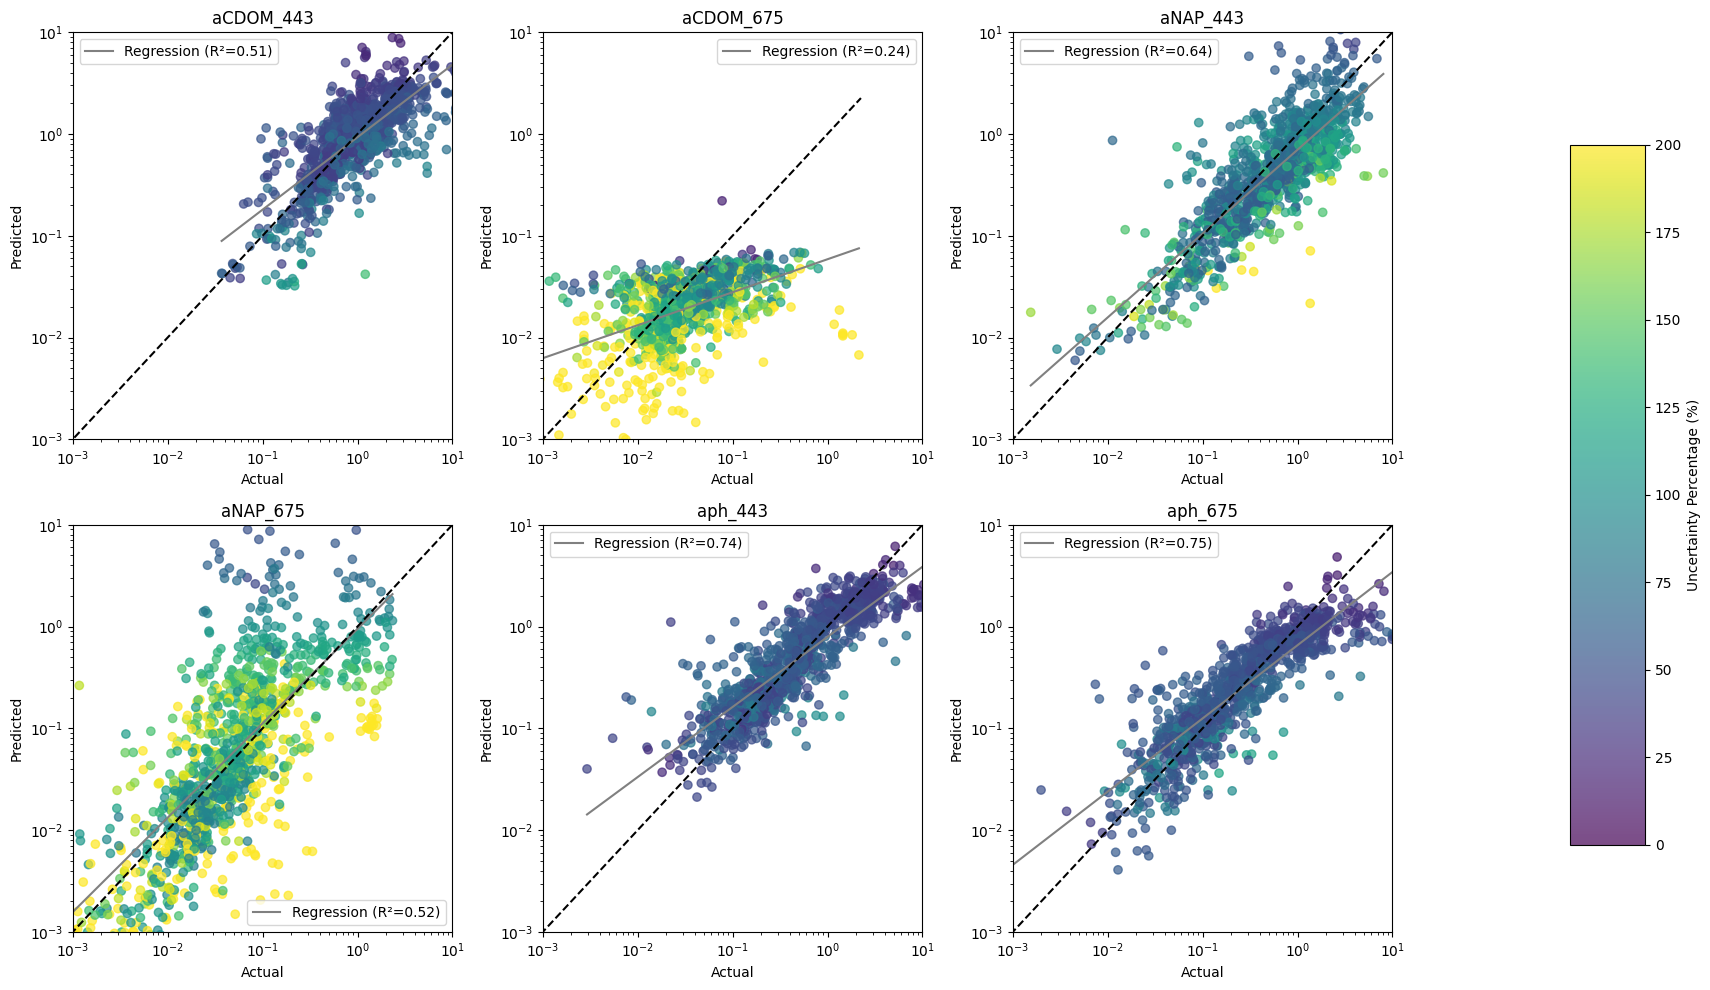

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
norm = plt.Normalize(vmin=0, vmax=200)


for i, ax in enumerate(axs):
    x_values = ood_y_test[:, i][mask[:, i]]
    y_values = ood_mean_preds[:, i][mask[:, i]]
    color_values = ood_percent_total_uncertainty[:, i][mask[:, i]]

    # Scatter plot
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.7)

    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.legend()

plt.tight_layout(rect=[0, 0, 0.95, 1])
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')
plt.show()

In [ ]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    ood_y_test,
    ood_mean_preds,
    ood_total_var,
    ood_aleatoric_var,
    ood_epistemic_var,
    ood_std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1159, 1159, 1159, 1159, 1159, 1159])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1159)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/bnn_dropcon_ood_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)
